# Wines Points prediction 

In [172]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
#pip install countryinfo

In [174]:
#pip install forex_python

In [175]:
import pandas as pd
from collections import Counter
import cufflinks as cf; cf.go_offline()
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import re
import numpy as np
import string
import emoji
import re as regex
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import warnings
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import cufflinks as cf; cf.go_offline()
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.graph_objects as go
import plotly.io as pio

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\or.nagari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\or.nagari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [176]:

warnings.filterwarnings('ignore')

In [177]:
wine_reviews = pd.read_csv("C:/Users/or.nagari/Python_ML_2023/data/winemag-data-130k-v2.csv")
wine_reviews.rename({'Unnamed: 0':'id'}, axis=1,inplace=True)
wine_reviews.shape

(129971, 14)

In [178]:
pd.set_option('display.max_colwidth', 300)

In [179]:
wine_reviews.head(1)

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


In [180]:
#Data Exploration

In [181]:
#check repetition in title and description 
#Has to drop the first coumn!
wine_reviews.drop('id', axis=1, inplace=True)

In [182]:
#wine_reviews.info()

In [183]:
#check duplicate

In [184]:
len(wine_reviews[wine_reviews.duplicated()])

9983

In [185]:
wine_reviews.shape

(129971, 13)

In [186]:
wine_reviews.drop_duplicates(inplace=True)
wine_reviews.shape

(119988, 13)

In [187]:
#check countries spelling
unique_countries = wine_reviews['country'].unique()

# Print the unique countries
unique_countries
# There are nulls values

array(['Italy', 'Portugal', 'US', 'Spain', 'France', 'Germany',
       'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa',
       'New Zealand', 'Israel', 'Hungary', 'Greece', 'Romania', 'Mexico',
       'Canada', nan, 'Turkey', 'Czech Republic', 'Slovenia',
       'Luxembourg', 'Croatia', 'Georgia', 'Uruguay', 'England',
       'Lebanon', 'Serbia', 'Brazil', 'Moldova', 'Morocco', 'Peru',
       'India', 'Bulgaria', 'Cyprus', 'Armenia', 'Switzerland',
       'Bosnia and Herzegovina', 'Ukraine', 'Slovakia', 'Macedonia',
       'China', 'Egypt'], dtype=object)

In [188]:
wine_reviews.describe()

,points,price
count,119988.000000,111593.000000
mean,88.442236,35.620747
std,3.092915,42.103728
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [189]:
#check unique values 
repetitive_description_count = wine_reviews['description'].value_counts()

# Print the repetitive titles with their counts
df = repetitive_description_count[repetitive_description_count > 1]
df.shape
#means that its not unique -Suspicies!!!!!

(33,)

In [190]:
# Assuming you have the "wine_reviews" DataFrame
repetitive_descriptions = wine_reviews[wine_reviews.duplicated(subset='description', keep=False)]

sorted_df = repetitive_descriptions .sort_values(by='description')
example_rows = sorted_df.head(2)
# Print the example repetitive descriptions
example_rows




,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
71853,France,"90–92. Barrel sample. This is a solid and dense wine with hints of bitter chocolate along with super-ripe blackberry fruits. The wine has concentration, richness and a fine ageing potential.",Barrel Sample,91,NaN,Bordeaux,Moulis-en-Médoc,NaN,Roger Voss,@vossroger,Château Maucaillou 2012 Barrel Sample (Moulis-en-Médoc),Bordeaux-style Red Blend,Château Maucaillou
71851,France,"90–92. Barrel sample. This is a solid and dense wine with hints of bitter chocolate along with super-ripe blackberry fruits. The wine has concentration, richness and a fine ageing potential.",Barrel Sample,91,NaN,Bordeaux,Margaux,NaN,Roger Voss,@vossroger,Château Pontac-Lynch 2012 Barrel Sample (Margaux),Bordeaux-style Red Blend,Château Pontac-Lynch


In [191]:
#check range of points
wine_reviews.points.unique()

array([ 87,  86,  85,  88,  92,  91,  90,  89,  83,  82,  81,  80, 100,
        98,  97,  96,  95,  93,  94,  84,  99], dtype=int64)

Text(0, 0.5, 'Frequency')

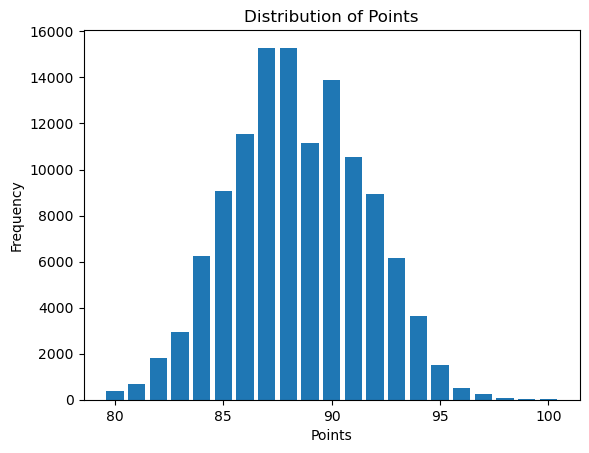

In [192]:
# Assuming you have the "wine_reviews" DataFrame
value_counts = wine_reviews['points'].value_counts().sort_index()
plt.bar(value_counts.index, value_counts.values)

plt.title('Distribution of Points')
plt.xlabel('Points')
plt.ylabel('Frequency')

In [193]:
#check avarage points
average_points = wine_reviews['points'].mean()
average_points

88.44223589025569

In [194]:
# average_points = wine_reviews.groupby('country')['points'].mean()
# average_points

In [195]:
# wine_reviews.points.describe()


In [196]:
wine_reviews.country.value_counts().div(wine_reviews.shape[0]).head()


US          0.420517
France      0.169625
Italy       0.149515
Spain       0.050972
Portugal    0.043804
Name: country, dtype: float64

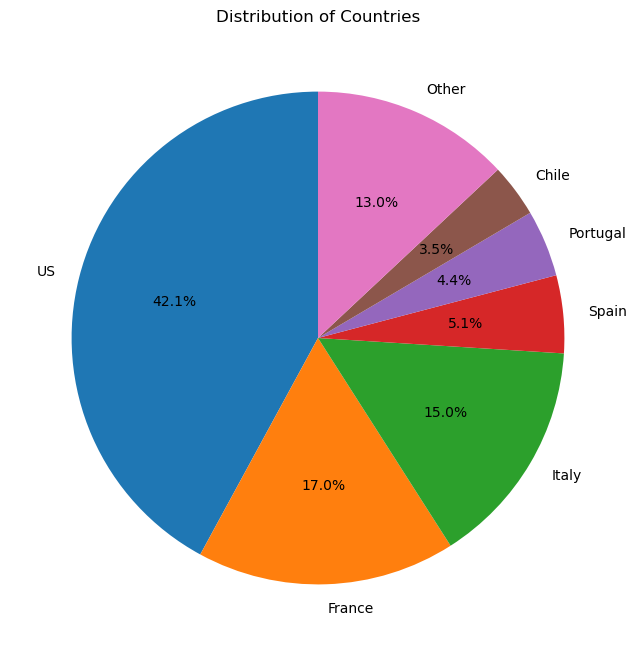

In [197]:


# Calculate the frequency of each country
country_counts = wine_reviews['country'].value_counts()

# Calculate the percentage of each country
country_percentages = country_counts / len(wine_reviews) * 100

# Filter out countries with less than 5% and replace their labels with 'Other'
other_countries_mask = country_percentages < 3
other_countries = country_percentages[other_countries_mask]
country_percentages = country_percentages[~other_countries_mask]
country_percentages['Other'] = other_countries.sum()

# Create a pie plot
plt.figure(figsize=(8, 8))
plt.pie(country_percentages, labels=country_percentages.index, autopct='%1.1f%%', startangle=90)

# Set the title of the plot
plt.title('Distribution of Countries')

# Display the plot
plt.show()


In [198]:
pd.concat([wine_reviews.country.value_counts().rename('counts'), 
          wine_reviews.country.value_counts().rename('proportion').div(wine_reviews.shape[0])], axis=1).head()

,counts,proportion
US,50457,0.420517
France,20353,0.169625
Italy,17940,0.149515
Spain,6116,0.050972
Portugal,5256,0.043804


In [199]:
# # Assuming you have the "wine_reviews" DataFrame
# value_counts = wine_reviews['points'].value_counts().sort_index()
# plt.bar(value_counts.index, value_counts.values)

# plt.title('Distribution of Points')
# plt.xlabel('Points')
# plt.ylabel('Frequency')

In [200]:
# add all the exploration

In [201]:
null_counts = wine_reviews.isnull().sum()
null_counts.sort_values(ascending=False)

region_2                 73219
designation              34545
taster_twitter_handle    29446
taster_name              24917
region_1                 19560
price                     8395
country                     59
province                    59
variety                      1
description                  0
points                       0
title                        0
winery                       0
dtype: int64

In [202]:
wine_reviews.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


In [203]:
#check if there is same name for different taters
distinct_tasters = wine_reviews[['taster_name', 'taster_twitter_handle']].drop_duplicates()

# Display the distinct tasters
distinct_tasters.sort_values(by='taster_name')

,taster_name,taster_twitter_handle
3,Alexander Peartree,NaN
8,Anna Lee C. Iijima,NaN
93,Anne Krebiehl MW,@AnneInVino
1625,Carrie Dykes,NaN
19831,Christina Pickard,@winewchristina
1627,Fiona Adams,@bkfiona
219,Jeff Jenssen,@worldwineguys
68,Jim Gordon,@gordone_cellars
77,Joe Czerwinski,@JoeCz
0,Kerin O’Keefe,@kerinokeefe


In [204]:
#remove columns region_2  and taster_twitter_handle
wine_reviews = wine_reviews.drop(["region_2", "taster_twitter_handle","designation"], axis=1)

In [205]:
null_counts = wine_reviews.isnull().sum()
null_counts.sort_values(ascending=False)

taster_name    24917
region_1       19560
price           8395
country           59
province          59
variety            1
description        0
points             0
title              0
winery             0
dtype: int64

In [206]:


# Update null values in the "taster_name" column to 'Unknown'
wine_reviews['taster_name'].fillna('Unknown', inplace=True)

# Update null values in the "region_1" column to 'Unknown'
wine_reviews['region_1'].fillna('Unknown', inplace=True)

#remove null values from variety- Only 59
wine_reviews= wine_reviews.dropna(subset=['country'])

#remove null values from variety- Only one
wine_reviews= wine_reviews.dropna(subset=['variety'])
# Calculate the average price for each country
average_prices = wine_reviews.groupby('country')['price'].transform('mean')


In [207]:
# Fill null values in the "price" column with the average prices
wine_reviews['price'].fillna(average_prices, inplace=True)

In [208]:
null_counts = wine_reviews.isnull().sum()
null_counts.sort_values(ascending=False)

price          1
country        0
description    0
points         0
province       0
region_1       0
taster_name    0
title          0
variety        0
winery         0
dtype: int64

In [209]:
null_price_records = wine_reviews[wine_reviews['price'].isnull()]

# Print the records with null price
null_price_records

,country,description,points,price,province,region_1,taster_name,title,variety,winery
110246,Egypt,"Ripe pear, apple and tropical fruit in the nose leads into easy-drinking yellow fruit flavors on the palate. Creamy with a clean finish—a great everyday sip that will pair well with poultry, salads, cheeses.",84,NaN,Egypt,Unknown,Susan Kostrzewa,Sahara Vineyards 2008 Caspar Blanc de Noirs Grenache (Egypt),Grenache,Sahara Vineyards


In [210]:
# Count the number of records with 'Egypt' as the country
egypt_count = wine_reviews[wine_reviews['country'] == 'Egypt'].shape[0]

# Print the count
print("Number of records with Egypt as the country:", egypt_count)

Number of records with Egypt as the country: 1


In [211]:
def extract_year(title):
    for word in title.split():
        if word.isdigit():
            if 1900 <= int(word) <= 2017:
                return word
        # elif word == 'NV':
        #     return word
        
    return None


In [212]:

#add Year Column
wine_reviews['year'] = wine_reviews['title'].apply(lambda i: extract_year(i))
wine_reviews.head(1)

,country,description,points,price,province,region_1,taster_name,title,variety,winery,year
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",87,39.928286,Sicily & Sardinia,Etna,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013


In [213]:
wine_reviews['year'].fillna(0, inplace=True)

In [214]:
wine_reviews['year'] = wine_reviews['year'].astype(int)

In [215]:
unique_years = wine_reviews['year'].unique()
sorted_unique_years = np.sort(unique_years)
sorted_unique_years

array([   0, 1904, 1912, 1919, 1927, 1929, 1934, 1935, 1941, 1945, 1947,
       1952, 1957, 1961, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1973,
       1974, 1976, 1978, 1980, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
       1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017])

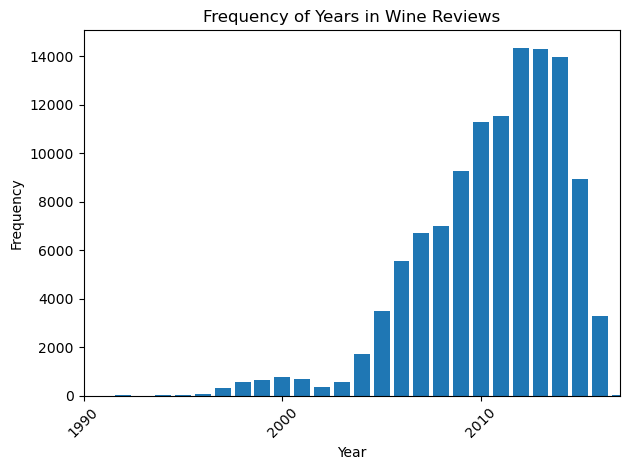

In [216]:
import matplotlib.pyplot as plt

# Group the data by year and count the occurrences
year_counts = wine_reviews['year'].value_counts().sort_index()

# Plot the frequency of years
#plt.figure(figsize=(10, 6))
plt.bar(year_counts.index, year_counts.values)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Years in Wine Reviews')
plt.xticks(range(1990, 2018, 10), rotation=45)  # Set the x-axis ticks at intervals of 10 years
plt.xlim(1990, 2017)  # Set the x-axis limits
plt.tight_layout()  # Adjust the spacing between the plot elements
plt.show()


In [217]:
#wine_reviews['year'].value_counts()

In [218]:
wine_reviews = wine_reviews.drop(["title"], axis=1)

In [219]:
#check outlires
year_counts = wine_reviews['year'].value_counts()

# Filter values with count less than 30
year_counts[year_counts < 30]


1994    23
1992    16
2017    11
1912     7
1929     6
1989     6
1990     5
1988     5
1985     4
1991     4
1986     3
1993     3
1963     3
1966     2
1984     2
1927     2
1952     2
1978     2
1983     2
1987     2
1964     2
1980     2
1973     1
1957     1
1934     1
1974     1
1941     1
1976     1
1961     1
1967     1
1919     1
1965     1
1982     1
1904     1
1969     1
1935     1
1947     1
1968     1
1945     1
Name: year, dtype: int64

In [220]:
year_counts[year_counts < 30].sum()

131

In [221]:
winery_counts = wine_reviews['winery'].value_counts()

# Filter values with count less than 30
winery_counts[winery_counts < 30]

Vistamar         29
Force Majeure    29
Ramey            29
Fontanafredda    29
Craggy Range     29
                 ..
Saldo             1
Montirius         1
PV Vinhos         1
Gregoletto        1
Penedo Borges     1
Name: winery, Length: 15981, dtype: int64

In [222]:
winery_counts[winery_counts < 10].sum()
#decide not to remove

40211

In [223]:
#outlires year and others

In [224]:
#year

# Assuming wine_reviews is the DataFrame containing the 'year' column

# Perform value counts on the 'year' column
year_counts = wine_reviews['year'].value_counts()

# Filter out years with counts less than 30
valid_years = year_counts[year_counts >= 30].index

# Filter the wine_reviews dataset
wine_reviews = wine_reviews[wine_reviews['year'].isin(valid_years)]



In [225]:
#contry less than 30

# Assuming wine_reviews is the DataFrame containing the 'country' column

# Perform value counts on the 'country' column
country_counts = wine_reviews['country'].value_counts()

# Filter out countries with counts less than 30
valid_countries = country_counts[country_counts >= 30].index

# Filter the wine_reviews dataset
wine_reviews = wine_reviews[wine_reviews['country'].isin(valid_countries)]
wine_reviews.shape

(119677, 10)

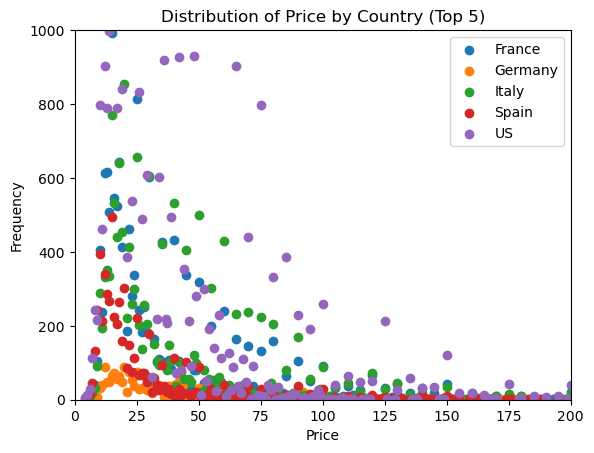

In [226]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the "wine_reviews" DataFrame
data = wine_reviews[['country', 'price']]  # Selecting the 'country' and 'price' columns

# Group the data by country and count the frequency of each unique price within each country
grouped_data = data.groupby('country')['price'].value_counts().sort_index()

# Reset the index
grouped_data = grouped_data.reset_index(name='frequency')

# Get the top 10 countries with the most frequency
top_5_countries = grouped_data['country'].value_counts().nlargest(5).index

# Filter the data for the top 10 countries
top_5_data = grouped_data[grouped_data['country'].isin(top_5_countries)]

# Create a scatter plot for each country
for country, values in top_5_data.groupby('country'):
    plt.scatter(values['price'], values['frequency'], label=country)

# Set the plot title and axes labels
plt.title('Distribution of Price by Country (Top 5)')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Set the range for the x-axis and y-axis
plt.xlim(0, 200)
plt.ylim(0, 1000)

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()


In [227]:
top_ten_countries = wine_reviews.country.value_counts().index[:10]
list(top_ten_countries)

['US',
 'France',
 'Italy',
 'Spain',
 'Portugal',
 'Chile',
 'Argentina',
 'Austria',
 'Australia',
 'Germany']

In [228]:
#wine_reviews.groupby('country')[['price','points']].corr(method = 'pearson').loc[top_ten_countries]

In [229]:
#Data cleaning
wine_reviews.shape

(119677, 10)

In [230]:
null_counts = wine_reviews.isnull().sum()
null_counts.sort_values(ascending=False)

country        0
description    0
points         0
price          0
province       0
region_1       0
taster_name    0
variety        0
winery         0
year           0
dtype: int64

In [231]:
print("\U0001F600")


😀


In [232]:
#ver 1
# Assuming the dataset includes English, French, and Spanish
nltk.download('stopwords')
stop_words = set(stopwords.words('english') + stopwords.words('french')+ stopwords.words('italian') + stopwords.words('spanish'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\or.nagari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [233]:

def clean_description(description):
    # Remove numbers, special characters, and links
    description = re.sub(r'\d+', '', description)  # Remove numbers
    description = re.sub(r'[^\w\s]', '', description)  # Remove special characters
    description = re.sub(r'http\S+|www.\S+', '', description)  # Remove links

    # Tokenize the description into words
    words = nltk.word_tokenize(description)

    # Remove stop words
    words = [word for word in words if word.lower() not in stop_words]

    # Join the words back into a cleaned description
    cleaned_description = ' '.join(words)
    
    return cleaned_description


In [234]:
# Clean the 'description' column
wine_reviews['cleaned_descriptions'] = wine_reviews['description'].apply(clean_description)


In [236]:
wine_reviews.head(1)

,country,description,points,price,province,region_1,taster_name,variety,winery,year,cleaned_descriptions
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",87,39.928286,Sicily & Sardinia,Etna,Kerin O’Keefe,White Blend,Nicosia,2013,Aromas include tropical fruit broom brimstone dried herb palate isnt overly expressive offering unripened apple citrus dried sage alongside brisk acidity


In [237]:
wine_reviews_Analysis = wine_reviews[['country', 'price', 'taster_name','province','region_1'
                                 ,'year','winery','points','cleaned_descriptions','variety']]

In [238]:


# Assuming you have the "wine_reviews_Analysis" DataFrame
cleaned_descriptions_list = list(wine_reviews_Analysis['cleaned_descriptions'])

# Create a list to store all the words
words = []

# Iterate over each cleaned description and extend the words list
for description in cleaned_descriptions_list:
    words.extend(description.split())

# Count the frequency of each word
word_counts = Counter(words)

# Convert the word counts to a DataFrame
word_frequency = pd.DataFrame.from_dict(word_counts, orient='index', columns=['Frequency'])

# Filter the words based on their count
word_frequency = word_frequency[(word_frequency['Frequency'] > 20) & (word_frequency['Frequency'] < len(cleaned_descriptions_list) / 2)]

# Sort the DataFrame by frequency in descending order
word_frequency = word_frequency.sort_values(by='Frequency', ascending=False)

# Reset the index and rename the columns
word_frequency = word_frequency.reset_index().rename(columns={'index': 'Word'})

# Display the word frequency DataFrame
words = word_frequency
words

,Word,Frequency
0,flavors,55443
1,fruit,41273
2,palate,34613
3,aromas,32311
4,finish,31968
...,...,...
6719,Testarossas,21
6720,Cornas,21
6721,proudly,21
6722,extroverted,21


In [239]:
#words

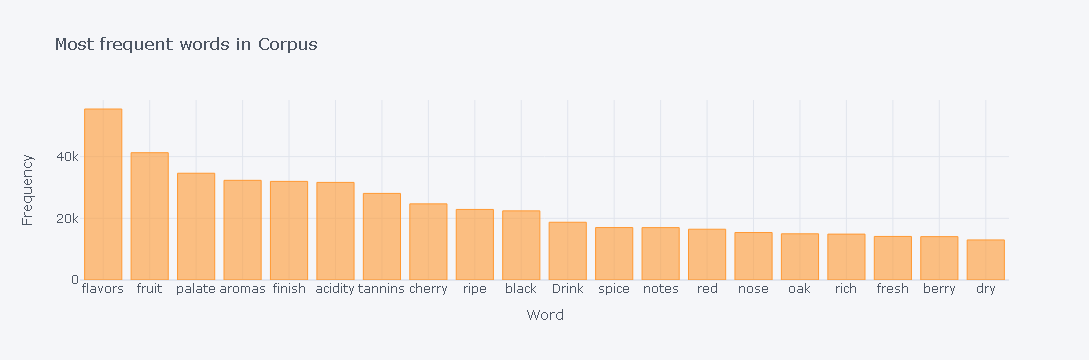

In [240]:


# Assuming you have the "words" DataFrame
words.set_index('Word')['Frequency'].head(20).iplot(kind='bar', title='Most frequent words in Corpus', yTitle='Frequency', xTitle='Word')


In [241]:
wine_reviews_Analysis.to_csv('wine_reviews_analysis.csv', index=False)